# Machine Learning - Project 2:
# _Autoencoder for mathematical modeling of blood flow in a stenosis context_

## Context

In this project, we are going to analyze data derived from...

Our goals:
1. modeliser mathématiquement l’écoulement sanguin à l’aide de PDE dépendante de 2-3 paramètres physique
2. simuler l’écoulement par un code d’éléments fini ou similaire
3. générer beaucoup de solutions avec une grande nombre de paramètres différents. (Les 2-3, pris de façon aléatoire)
4. a. utiliser les solutions numérique pour établir un auto encoder qui au milieu n’ai que 2-5 hyper-paramètres libres  
b. quel erreur on obtient ? Est-ce possible de réduire le nombre d’hyper-paramètres ?
5. étudier s’il y a une rélation entre les 2-5 hyper-paramètre et les paramètres physique  
a. à l’aide de statistiques
5. b. à l’aide d’un DNN (différent de 4a)
6. (optionnel) faire un DNN entre l’input de 4a et output les paramêtres physique. Et/ou l’inverse.
7. Discussion et conclusions 

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. Autoencoder](#autoencoder)

### Imports  <a name="1imports"></a>

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from autoencoder import *
from crossvalidation import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)
np.random.seed(1)
seed = 1

## 1. Data exploration  <a name="data_exploration"></a>

### Pathways <a name="1pathways"></a>

In [18]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_very_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_very_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [19]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [20]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (137725, 110)
Our input array Uy is of shape: (137725, 110)
Printing a row of Ux: 
 [0.0694243  0.27537487 0.60389834 1.02538242 1.49979277 1.9813229
 2.42318455 2.78232553 3.02371067 3.12378595 3.22605803 3.32166836
 3.41249686 3.49946177 3.58301614 3.66339786 3.74073801 3.81511138
 3.88656184 3.95511576 4.02078945 4.08359325 4.14353388 4.20061589
 4.2548424  4.30621561 4.35473712 4.40040807 4.44322934 4.48320158
 4.52032526 4.55460075 4.58602833 4.61460821 4.64034055 4.66322547
 4.68326307 4.70045341 4.71479655 4.72629252 4.73494137 4.7407431
 4.74369775 4.74423086 4.74375285 4.74246986 4.74042825 4.73764939
 4.73414407 4.72991811 4.7249748  4.71931611 4.71294324 4.70585693
 4.6980577  4.68954587 4.68032167 4.67038525 4.65973675 4.64837623
 4.63630377 4.6235194  4.61002317 4.5958151  4.5808952  4.5652635
 4.54892001 4.53186473 4.51409767 4.49561883 4.47642823 4.45652585
 4.43591171 4.41458581 4.39254814 4.36979872 4.34633752 4.32216457
 4.29727986 4.27

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [21]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran ", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at ", positions, " different positions and at ", times, " different times")

We ran  25 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at  5509  different positions and at  110  different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [22]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

ADDITIONAL IDEAS FOR PREPROCESSING
- remove columns with 0 std dev?
- standardization?

Let's sample our data points into the following ratios : 

In [53]:
ratio_pts = 0.1
ratio_time = 0.5

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(13750, 55) (13750, 55)


In [54]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from ', 5509, ' positions to ', new_Nu, ' positions')
print('With the sampling we got from ', 110, ' time steps to ', new_Nt, ' time steps')

With the sampling we got from  5509  positions to  550  positions
With the sampling we got from  110  time steps to  55  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery :

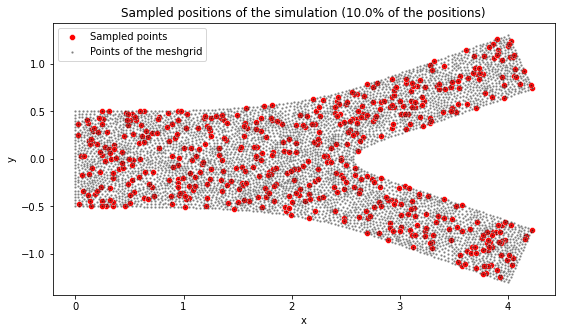

In [55]:
plot_sampled_coord(new_inds) 

In [26]:
print(new_Ux)

[[0.05835955 0.49017009 1.1771073  ... 2.3972929  2.33386954 2.26842866]
 [0.01521457 0.10728349 0.22658085 ... 0.34120634 0.33186228 0.32222659]
 [0.05227898 0.43588769 1.03893716 ... 2.03544675 1.98129714 1.92543036]
 ...
 [0.08793295 0.77062365 1.91659264 ... 4.29471327 4.18221467 4.06611756]
 [0.04154516 0.28052928 0.56214566 ... 0.6288614  0.61074307 0.59207462]
 [0.05565444 0.41835948 0.93252481 ... 1.679056   1.63414775 1.58781946]]


Let's flatten our matrices into a single matrix with dimensions $(N_s, (2 N_u N_t))$. For each simulation, the x and y speed coordinates are compressed to the following 1D matrix:

$$
\mathbf{M_{1D}}
=
\begin{bmatrix}
\vdots \\
u_{x}^{(0)} \\
\vdots \\
u_{y}^{(0)} \\
\vdots \\
u_{x}^{(1)} \\
\vdots \\
u_{y}^{(1)} \\
\vdots \\
u_{x}^{(N_t - 1)} \\
\vdots \\
u_{y}^{(N_t - 1)} \\
\vdots 
\end{bmatrix}
$$



In [27]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 60500)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u}}$.

In [28]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

60500


## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle : 

In the following cell, we will create pickles for every subsampled data according to the ratios_pts and the ratios_t :

In [14]:
'''
ratios_pts = [0.1, 0.05, 0.02]
ratios_t = [0.5, 0.25, 0.1]

create_subsamples(Ux, Uy, ratios_pts, ratios_t, name_file='middle_small')
'''

#### Start from here if you the pickle file already exist in your data folder

Change only the following cell to change the name of the file you want to open :

In [78]:
ratios = [0.1, 0.5]
size = ['very_small', 'middle_small', 'small']

name = 'processed_'+str(size[1])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read : ', name)

name of the file you want to read :  processed_middle_small_0.1_0.5


In [79]:
flattened_array  = cPickle.load(open("data/pickle/"+str(size[1])+"/"+name, "rb"))

In [80]:
print(flattened_array)

[[ 6.59818698e-02  1.82234920e-02  6.44159502e-02 ...  1.03034493e+00
  -9.73947264e-03 -1.67477632e-02]
 [ 5.29771523e-02  1.32216300e-02  4.90189335e-02 ...  9.93200215e-01
   5.02639122e-03  1.41599883e-03]
 [ 8.25671280e-02  2.32952726e-02  6.87771891e-02 ...  1.77500861e+00
   3.44533164e-04  1.81417079e-02]
 ...
 [ 2.19606656e-01  2.55903473e-02  2.29397872e-01 ...  1.46759534e+00
   7.42708226e-02 -1.34336791e-02]
 [ 2.41341112e-01  5.06083120e-02  2.15209040e-01 ...  4.44840207e+00
   4.35858394e-02  2.36892166e-02]
 [ 6.98710694e-02  1.96083000e-02  6.43463295e-02 ...  1.38366628e+00
  -1.23426650e-03  1.73919218e-03]]


##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [81]:
x_train, x_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = x_train, x_test

print(x_train.shape)
print(x_test.shape)

(157, 60500)
(18, 60500)


## 4. Feed-forward auto-encoder  <a name="autoencoder"></a>

#### Parameters tuning

Find the best learning rate of our model using cross-validation :

In [ ]:
plt.plot(learning_rates, results, 'bo')
plt.plot(best_learning_rate, best_result, 'ro', markersize=8, label = 'Best learning rate :'+str(best_learning_rate)+ endl +'error : ' + str(round(best_result, 3)))
plt.xlabel('Learning rate') ; plt.ylabel('Test error')
title = 'Average test error on the ' + str(k_folds) + '-fold for different learning rates'
plt.title(title)
plt.legend()
plt.savefig("Learning_rate_tuning_"+dataset_name_)
plt.show()

In [82]:
# define network parameters
learning_rates =[1e-2, 1e-3, 1e-4, 1e-5]
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Learning rate =  0.01

Performance of 5 fold cross validation: 
Average Training Error: 0.440 	 Average Test Error: 0.384
 
Learning rate =  0.001

Performance of 5 fold cross validation: 
Average Training Error: 0.405 	 Average Test Error: 0.337
 
Learning rate =  0.0001

Performance of 5 fold cross validation: 
Average Training Error: 0.412 	 Average Test Error: 0.374
 
Learning rate =  1e-05

Performance of 5 fold cross validation: 
Average Training Error: 0.630 	 Average Test Error: 0.623
 

Best learning rate is  0.001  with a best error of :  0.3365137743885207



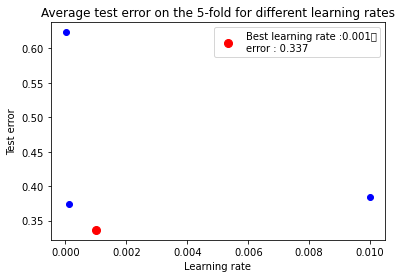

In [83]:
best_result, best_lr = tuning_lr(x_train, k_folds, input_size, epochs, criterion, learning_rates,  dataset_name_=dataset_name)

Find the best number of neurons in the latent space (neurons in the "middle layer of the auto-encoder") in the auto-encoder (which is actually the dimension of the compressed data) : 

In [85]:
# define network parameters
lr = best_lr # from above
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
number_neurons = [3, 4, 5, 6, 7, 8, 9, 10]
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Number of neurons =  3

Performance of 5 fold cross validation: 
Average Training Error: 0.325 	 Average Test Error: 0.299
 
Number of neurons =  4

Performance of 5 fold cross validation: 
Average Training Error: 0.359 	 Average Test Error: 0.446
 
Number of neurons =  5

Performance of 5 fold cross validation: 
Average Training Error: 0.405 	 Average Test Error: 0.337
 
Number of neurons =  6

Performance of 5 fold cross validation: 
Average Training Error: 0.367 	 Average Test Error: 0.354
 
Number of neurons =  7

Performance of 5 fold cross validation: 
Average Training Error: 0.442 	 Average Test Error: 0.384
 
Number of neurons =  8

Performance of 5 fold cross validation: 
Average Training Error: 0.382 	 Average Test Error: 0.352
 
Number of neurons =  9

Performance of 5 fold cross validation: 
Average Training Error: 0.367 	 Average Test Error: 0.389
 
Number of neurons =  10

Performance of 5 fold cross validation: 
Average Training Error: 0.421 	 Average Test Error: 0.424
 

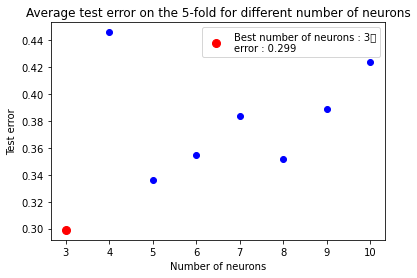

In [86]:
best_result, best_neurons_nb = tuning_latent_layer(x_train, k_folds, input_size, epochs, criterion, lr, number_neurons,  dataset_name_=dataset_name)

#### Let's try with the tuned parameters and see how it goes along the epochs

In [87]:
# define network parameters
learningRate= best_lr
epochs=50
input_size=x_train.shape[1]
k_folds = 3
neuron_ = 3

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:0.926 Test Error:0.928
Epoch:2/50 Training Error:0.630 Test Error:0.480
Epoch:3/50 Training Error:0.465 Test Error:0.438
Epoch:4/50 Training Error:0.429 Test Error:0.394
Epoch:5/50 Training Error:0.436 Test Error:0.442
Epoch:6/50 Training Error:0.455 Test Error:0.405
Epoch:7/50 Training Error:0.383 Test Error:0.373
Epoch:8/50 Training Error:0.409 Test Error:0.385
Epoch:9/50 Training Error:0.357 Test Error:0.407
Epoch:10/50 Training Error:0.364 Test Error:0.415
Epoch:11/50 Training Error:0.389 Test Error:0.367
Epoch:12/50 Training Error:0.352 Test Error:0.364
Epoch:13/50 Training Error:0.349 Test Error:0.388
Epoch:14/50 Training Error:0.329 Test Error:0.356
Epoch:15/50 Training Error:0.389 Test Error:0.371
Epoch:16/50 Training Error:0.417 Test Error:0.363
Epoch:17/50 Training Error:0.330 Test Error:0.532
Epoch:18/50 Training Error:0.340 Test Error:0.340
Epoch:19/50 Training Error:0.304 Tes

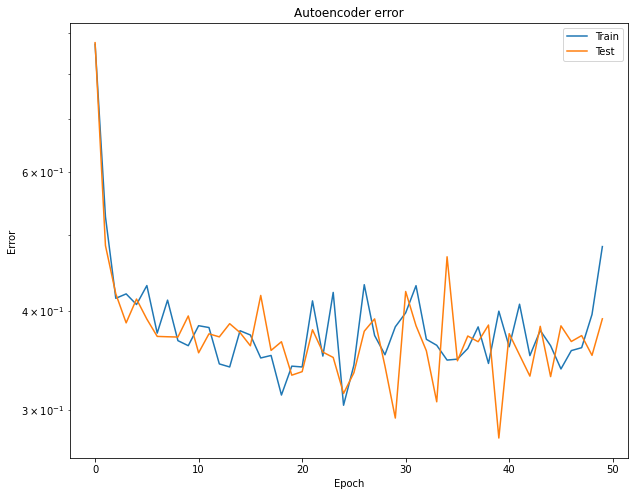

0.39110623576203246

In [88]:
Kfold(x_train, k_folds, input_size, epochs, criterion, learningRate, neuron=neuron_)

#### Quality of the compression on the test set using the tuned parameters :

We will now train and test our auto-encoder for different sample size of our initial dataset. To do so we will do a batch processing and store the final train and test errors. See the report to see the nice comparison table :

In [89]:
import glob
import os 
import _pickle as cPickle

dataset = 'middle_small'
file_location = os.path.join('data', 'pickle', dataset, '*')
filenames = glob.glob(file_location)
i=0 


# define the parameters of the model
learningRate= 0.001
neuron_ = 3

epochs=50
criterion = nn.MSELoss() 

test_errors = []
train_errors = []
names = [] #Just to be sure of which error corresponds to which sub-dataset

for f in filenames:
    
    print("\033[1m" +'Train/Test of the sub-dataset ' + f + "\033[0m")
    
    #Load the data
    x  = cPickle.load(open(f, "rb"))
    
    #Split
    x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed)
    y_train, y_test = x_train, x_test
    
    #Declare the model
    input_size=x_train.shape[1]
    model = Autoencoder(input_size, neuron_)
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-5)
    
    #Dataloader
    train_loader = DataLoader(x_train)
    test_loader = DataLoader(x_test)
    
    #Training and testing over the epochs
    for epoch in range(epochs):
        # train the model 
        train_loss=train_epoch(train_loader, model, criterion, optimizer)
        # compute the relative training error
        train_error = valid_epoch(train_loader, model)
        # compute the relative test error
        test_error=valid_epoch(test_loader, model)
        
        print("Epoch:{}/{} Training Error:{:.3f} Test Error:{:.3f}".format(epoch + 1,epochs,train_error,test_error))
    
    #Save the last epoch train and test errors
    test_errors.append(test_error)
    train_errors.append(train_error)
    names.append(f)

Train/Test of the sub-dataset data\pickle\middle_small\processed_middle_small_0.02_0.1
Epoch:1/50 Training Error:0.167 Test Error:0.167
Epoch:2/50 Training Error:0.130 Test Error:0.127
Epoch:3/50 Training Error:0.122 Test Error:0.117
Epoch:4/50 Training Error:0.117 Test Error:0.112
Epoch:5/50 Training Error:0.116 Test Error:0.111
Epoch:6/50 Training Error:0.116 Test Error:0.111
Epoch:7/50 Training Error:0.116 Test Error:0.112
Epoch:8/50 Training Error:0.117 Test Error:0.112
Epoch:9/50 Training Error:0.122 Test Error:0.118
Epoch:10/50 Training Error:0.117 Test Error:0.113
Epoch:11/50 Training Error:0.116 Test Error:0.112
Epoch:12/50 Training Error:0.116 Test Error:0.112
Epoch:13/50 Training Error:0.115 Test Error:0.112
Epoch:14/50 Training Error:0.117 Test Error:0.113
Epoch:15/50 Training Error:0.119 Test Error:0.115
Epoch:16/50 Training Error:0.116 Test Error:0.112
Epoch:17/50 Training Error:0.116 Test Error:0.112
Epoch:18/50 Training Error:0.116 Test Error:0.112
Epoch:19/50 Training E

Epoch:8/50 Training Error:0.109 Test Error:0.110
Epoch:9/50 Training Error:0.109 Test Error:0.109
Epoch:10/50 Training Error:0.109 Test Error:0.110
Epoch:11/50 Training Error:0.116 Test Error:0.118
Epoch:12/50 Training Error:0.110 Test Error:0.111
Epoch:13/50 Training Error:0.109 Test Error:0.111
Epoch:14/50 Training Error:0.110 Test Error:0.111
Epoch:15/50 Training Error:0.110 Test Error:0.112
Epoch:16/50 Training Error:0.113 Test Error:0.116
Epoch:17/50 Training Error:0.116 Test Error:0.119
Epoch:18/50 Training Error:0.111 Test Error:0.113
Epoch:19/50 Training Error:0.109 Test Error:0.110
Epoch:20/50 Training Error:0.109 Test Error:0.110
Epoch:21/50 Training Error:0.108 Test Error:0.110
Epoch:22/50 Training Error:0.109 Test Error:0.110
Epoch:23/50 Training Error:0.109 Test Error:0.111
Epoch:24/50 Training Error:0.109 Test Error:0.110
Epoch:25/50 Training Error:0.108 Test Error:0.110
Epoch:26/50 Training Error:0.108 Test Error:0.110
Epoch:27/50 Training Error:0.111 Test Error:0.113
Ep

Epoch:17/50 Training Error:0.109 Test Error:0.109
Epoch:18/50 Training Error:0.104 Test Error:0.105
Epoch:19/50 Training Error:0.104 Test Error:0.104
Epoch:20/50 Training Error:0.104 Test Error:0.105
Epoch:21/50 Training Error:0.104 Test Error:0.104
Epoch:22/50 Training Error:0.116 Test Error:0.113
Epoch:23/50 Training Error:0.114 Test Error:0.116
Epoch:24/50 Training Error:0.107 Test Error:0.107
Epoch:25/50 Training Error:0.105 Test Error:0.105
Epoch:26/50 Training Error:0.104 Test Error:0.104
Epoch:27/50 Training Error:0.104 Test Error:0.104
Epoch:28/50 Training Error:0.104 Test Error:0.104
Epoch:29/50 Training Error:0.104 Test Error:0.104
Epoch:30/50 Training Error:0.104 Test Error:0.104
Epoch:31/50 Training Error:0.104 Test Error:0.104
Epoch:32/50 Training Error:0.104 Test Error:0.104
Epoch:33/50 Training Error:0.105 Test Error:0.106
Epoch:34/50 Training Error:0.104 Test Error:0.104
Epoch:35/50 Training Error:0.105 Test Error:0.106
Epoch:36/50 Training Error:0.104 Test Error:0.105


In [90]:
from pandas import *

#If you want to load the test and train errors from the saved pickles files, uncomment following lines :
'''
dataset = "middle_small"
train_errors  = cPickle.load(open("data/pickle/results/"+"train_errors_" + dataset, "rb"))
test_errors  = cPickle.load(open("data/pickle/results/"+"test_errors_" + dataset, "rb"))
'''

results = DataFrame({'' : ['50%', '25%', '10%'],
                   '10%' : test_errors[:3][::-1],
                   '5%' : test_errors[3:6][::-1],
                   '2%' : test_errors[6:9][::-1]})

results = results.set_index('')

display(results)
print("\033[1m" + 'Table of relative error depending on the sampling of the dataset' + "\033[0m")
print('x : sampling of times')
print('y : sampling of positions')

,10%,5%,2%
,,,
50%,0.115779,0.119474,0.109854
25%,0.120044,0.115242,0.609663
10%,0.113816,0.111220,0.105020


Table of relative error depending on the sampling of the dataset
x : sampling of times
y : sampling of positions


In [92]:
#Save in pickles
name = "train_errors_" + dataset
cPickle.dump( train_errors , open( name, "wb" ) )
name = "test_errors_" + dataset
cPickle.dump( test_errors , open( name, "wb" ) )

## 4. Passer en 2D 

Instead of flattenning our initial dataset into a colummn vector for each simulation, we split it into a 2D matrix for each simulation such as the following:

$$
\mathbf{M_{2D}}
=
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots \\
u_{x}^{(0)} & u_{x}^{(1)} & \cdots &
u_{x}^{(N_t - 1)} \\
\vdots & \vdots & \ddots & \vdots \\
u_{y}^{(0)} & u_{y}^{(1)} & \cdots &
u_{y}^{(N_t - 1)} \\
\vdots & \vdots & \vdots & \vdots
\end{bmatrix}
$$

In [16]:
flattened_array = flatten_2d(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 1100, 110)

## 5. Passer en 4D

In [11]:
flattened_array_4d = flatten_4d(new_Ux, new_Uy, ratio_pts)
flattened_array_4d.shape

IndexError: index 55 is out of bounds for axis 1 with size 55

In [ ]:
flattened_array_4d = normalize(flattened_array_4d)

In [ ]:
x_train, x_test = train_test_split(flattened_array_4d, test_size=0.1, random_state=seed)

In [ ]:
import h5py

In [ ]:
hf = h5py.File('trainset.h5', 'w')
hf.create_dataset('dataset_1', data=x_train)

In [ ]:
hf = h5py.File('testset.h5', 'w')
hf.create_dataset('dataset_1', data=x)

## 6. Discussion & conclusion